#Projet IMA - Segmentation de lésion cutannée | C.TEISSIER & T.BLANCHARD

L'objectif de ce projet est de développer des méthodes de segmentation pour des images de lésions cutanées. On utlise ici une base de données issues de l'ISIC. Les références utilisées comme base du projet sont précisées à la fin du notebook. Ce notebook est fait pour être exécuté sur Google Collab

##Ouverture des fichiers et import des modules

In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='1s4E3D9B25wHPCKHtEVy7E3LyH2VbqW5u',
dest_path='./data/allfiles.zip')
import zipfile
with zipfile.ZipFile('./data/allfiles.zip', 'r') as zip_ref:
    zip_ref.extractall('./data/')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
import copy
from scipy import ndimage as ndi
from skimage import io as skio
from skimage import filters
from skimage import color
from skimage import exposure
from skimage.morphology import disk, square
from skimage import morphology as morpho
from skimage import segmentation as seg
from skimage.transform import resize

##Choix de l'image

Nous avons utilisé d'abord une méthode classique de seuillage avec la méthode d'Otsu qui donnait des résultats corrects (1er dice indiqué) puis une deuxième méthode faisant appel à la couleur de la peau qui fonctionne beaucoup mieux (2e dice indiqué).

In [ ]:
#Exemple d'image simple, dice = 0.99 / 0.99
#im=skio.imread('/content/data/skin_lesion_dataset-master/melanoma/ISIC_0000145.jpg')
#im_segmented = skio.imread('/content/data/skin_lesion_dataset-master/melanoma/ISIC_0000145_Segmentation.png')

#Exemple d'image avec cadre noir, dice = 0.93 / 0.97
im=skio.imread('/content/data/skin_lesion_dataset-master/melanoma/ISIC_0000146.jpg')
im_segmented = skio.imread('/content/data/skin_lesion_dataset-master/melanoma/ISIC_0000146_Segmentation.png')

#Exemple d'image où la segmentation est difficile à cause des différences de couleurs, dice = 0.85 / 0.94 avec 2 passages
#im=skio.imread('/content/data/skin_lesion_dataset-master/melanoma/ISIC_0000030.jpg')
#im_segmented = skio.imread('/content/data/skin_lesion_dataset-master/melanoma/ISIC_0000030_Segmentation.png')

#Exemple d'image où l'image de référence n'est pas précise, dice = 0.93 / 0.91
#im=skio.imread('/content/data/skin_lesion_dataset-master/melanoma/ISIC_0000143.jpg')
#im_segmented = skio.imread('/content/data/skin_lesion_dataset-master/melanoma/ISIC_0000143_Segmentation.png')

#Exemple d'image où la segmentation est génée par les poils qui recouvrent la lésion, dice = 0.95 / 0.92
#im=skio.imread('/content/data/skin_lesion_dataset-master/nevus/ISIC_0000095.jpg')
#im_segmented = skio.imread('/content/data/skin_lesion_dataset-master/nevus/ISIC_0000095_Segmentation.png')

#Autres tests
#im=skio.imread('/content/data/skin_lesion_dataset-master/nevus/ISIC_0000042.jpg')
#im_segmented = skio.imread('/content/data/skin_lesion_dataset-master/nevus/ISIC_0000042_Segmentation.png')


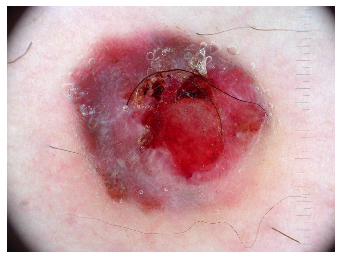

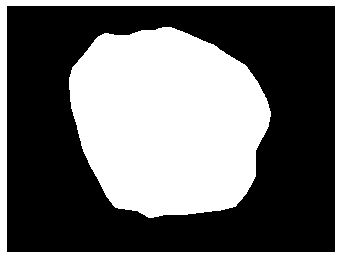

In [ ]:
(l,c,k)= np.shape(im)
if (l > 1000):
    resize(im, (700,math.floor(c*700/l)), anti_aliasing=True)
skio.imshow(im)
plt.axis('off')
skio.show()
skio.imshow(im_segmented)
plt.axis('off')
skio.show()


# Détermination du masque poils


L'objectif ici est de détecter les poils lorsqu'il y en a et de les enlever de l'image. On utilise l'algorithme du DullRazor [4]. On va en sortie de cette partie disposer à la fois d'un masque correspondant au masque et d'une nouvelle version de l'image où les poils ont été retirés.

In [ ]:
# 512x486, On se remet dans le même format que dans l'article DullRazor.
def resize_im(im, im_segmented):
    im_resized = resize(im, (512,486),anti_aliasing=True)
    im_r = im_resized[:,:,0]
    im_g = im_resized[:,:,1]
    im_b = im_resized[:,:,2]
    return im_r, im_g, im_b, im_resized

#### Éléments structurants

In [ ]:
s0 = np.array([[0,1,1,1,1,1,1,1,1,1,0]])
s90 = np.array([[0],[1],[1],[1],[1],[1],[1],[1],[1],[1],[0]])
s45 = np.array([
       [0,0,0,0,0,0,0,0,0],
       [0,1,0,0,0,0,0,0,0],
       [0,0,1,0,0,0,0,0,0],
       [0,0,0,1,0,0,0,0,0],
       [0,0,0,0,1,0,0,0,0],
       [0,0,0,0,0,1,0,0,0],
       [0,0,0,0,0,0,1,0,0],
       [0,0,0,0,0,0,0,1,0],
       [0,0,0,0,0,0,0,0,0]
])
elements = [s0,s45,s90]

#### Closing

In [ ]:
def gclosing(im,elements):
  ''' Réalise la fermeture morphologique selon chacun des élements structurants'''
  im_s0 = morpho.closing(im,elements[0])
  im_s45 = morpho.closing(im,elements[1])
  im_s90 = morpho.closing(im,elements[2])
  return (im_s0,im_s45,im_s90)

In [ ]:
def gclosing_application(im_r, im_g, im_b, elements):
    ''' On réalise la fermeture selon chacun des éléments structurants sur chaque canal'''
    im_rs0,im_rs45,im_rs90 = gclosing(im_r,elements)
    im_gs0,im_gs45,im_gs90 = gclosing(im_g,elements)
    im_bs0,im_bs45,im_bs90 = gclosing(im_b,elements)
    return im_rs0,im_rs45,im_rs90, im_gs0,im_gs45,im_gs90, im_bs0,im_bs45,im_bs90

In [ ]:
def tripleMaxTab(im_bs0,im_bs45,im_bs90):
  (l,w) = np.shape(im_bs0)
  out = np.copy(im_bs0)
  for i in range(l):
    for j in range(w):
      out[i,j] = np.max([im_bs0[i,j],im_bs45[i,j],im_bs90[i,j]])
  return out

In [ ]:
def tripleMaxTab_application(im_r, im_g, im_b, im_rs0,im_rs45,im_rs90, im_gs0,im_gs45,im_gs90, im_bs0,im_bs45,im_bs90):
    ''' On applique la formule (1) de l'article DullRazor'''
    gr =np.abs(im_r - tripleMaxTab(im_rs0,im_rs45,im_rs90) )
    gg =np.abs(im_g - tripleMaxTab(im_gs0,im_gs45,im_gs90) )
    gb =np.abs(im_b - tripleMaxTab(im_bs0,im_bs45,im_bs90) )
    return gr, gg, gb

#### Seuillage

In [ ]:
def calcul_masque_poils(gr, gg, gb):
    '''Formule (2) et (3) de l'article avec une valeur du seuil adapté à la plage des valeurs'''
    t = 0.0941176470588235294117647058823 # On rapporte la valeur de 24/255 du papier à [0;1]

    mr = np.where(gr >= t,1,0)
    mg = np.where(gg >= t,1,0)
    mb = np.where(gb >= t,1,0)
    mbol = (mr == 1) | (mg == 1) | (mb == 1)
    m = mbol.astype(int)
    return m

In [ ]:
def affichage_masque_poils(m, im_resized):

    mAndImage = np.copy(im_resized)
    (l,w,c) = np.shape(im_resized)
    for i in range(l):
      for j in range(w):
        if m[i][j] : mAndImage[i,j] = [0,0,255]
    
    f = plt.figure(figsize=(12,15))
    f.add_subplot(1,3, 1)
    plt.imshow(m,cmap='gray')
    plt.title("Masque")
    plt.axis('off')
    f.add_subplot(1,3, 2)
    plt.imshow(im)
    plt.axis('off')
    plt.title("Image de base")
    f.add_subplot(1,3,3)
    plt.imshow(mAndImage)
    plt.title("Image + masque")
    plt.axis('off')
    plt.show()

In [ ]:
def calcul_complet_masque(im, im_segmented):
    im_r, im_g, im_b, im_resized = resize_im(im, im_segmented)
    im_rs0,im_rs45,im_rs90, im_gs0,im_gs45,im_gs90, im_bs0,im_bs45,im_bs90 = gclosing_application(im_r, im_g, im_b, elements)
    gr, gg, gb = tripleMaxTab_application(im_r, im_g, im_b, im_rs0,im_rs45,im_rs90, im_gs0,im_gs45,im_gs90, im_bs0,im_bs45,im_bs90)
    m = calcul_masque_poils(gr, gg, gb)
    affichage_masque_poils(m, im_resized)
    return m

 ### Nettoyage du masque

On a alors obtient un masque des poils. Cependant, il présente un certain nombre de défauts. En particulier on va détecter des motifs qui ne sont pas des poils. On va alors appliquer les critères décrits dans l'article en allant étudier la longueur et la largeur des segments que l'on peut tracer dans le masque afin de savoir si les pixels du masque correspondent bien à des poils.

#### Longueur des lignes

On calcule ici la longueur d'un segment partant du pixel (x,y) dans les 8 directions en restant dans le masque

In [ ]:
def ligneg(im,x,y):
  #ligne à gauche
  i = y
  leng = 0
  while i> 0 and im[x,i] == 1 :
    leng += 1 
    i -= 1
  return leng

def ligned(im,x,y):
  #ligne à droite
  (l,w) = im.shape
  i = y
  lend = 0
  while i < w and im[x,i] == 1 :
    lend += 1 
    i += 1
  return lend

def ligneb(im,x,y):
  (l,w) = im.shape
  #ligne en bas
  i = x
  lenb = 0
  while i < l and im[i,y] == 1 :
    lenb += 1 
    i += 1
  return lenb

def ligneh(im,x,y):
  (l,w) = im.shape
  #ligne vers le haut
  i = x
  lenh = 0
  while i > 0 and im[i,y] == 1 :
    lenh += 1 
    i -= 1
  return lenh

def lignediaghg(im,x,y):
    #diag haute gauche
    (l,w) = im.shape
    i,j = x,y
    lendiaghg = 0 
    while i>0 and j>0 and im[i,j] == 1 :
      lendiaghg += 1 
      i -= 1
      j -= 1
    return lendiaghg

def lignediaghd(im,x,y):
    #diag haute droite
    (l,w) = im.shape
    i,j = x,y
    lendiaghd = 0 
    while i>0 and j<w and im[i,j] == 1 :
      lendiaghd += 1 
      i -= 1
      j += 1
    return lendiaghd

def lignediagbg(im,x,y):
    #diag basse gauche
    (l,w) = im.shape
    i,j = x,y
    lendiagbg = 0 
    while i<l and j>0 and im[i,j] == 1 :
      lendiagbg += 1 
      i += 1
      j -= 1
    return lendiagbg

def lignediagbd(im,x,y):
    #diag basse droite
    (l,w) = im.shape
    i,j = x,y
    lendiagbd = 0 
    while i<l and j<w and im[i,j] == 1 :
      lendiagbd += 1 
      i += 1
      j += 1
    return lendiagbd

#### Changement du masque

In [ ]:
def dirnorm(lenligne):
  '''
  Donne le direction normale au segment le plus grand : 0-> horizontale, 1->verticale, 2->diag 45° sens trigo, 3-> diag -45° sens trigo
  '''
  argmaxlen = np.argmax(lenligne)
  if argmaxlen == 0 or argmaxlen == 1 : return 1
  elif argmaxlen ==  2 or argmaxlen == 3 : return 0
  elif argmaxlen ==  4 or argmaxlen == 5 : return 3
  elif argmaxlen ==  6 or argmaxlen == 7 : return 2
  else : 
    print("GROS PROBLEME DE TAILLE")
    return(-1)

def taillepoil(lenligne,mbis,i,j):
  '''
  Détermine, en se basant sur la taille des segments déterminées avant, si on peut considérer que le pixel aux coordonnées[i,j] fait bien partie d'un poil.
  Si non on l'enlève du masque.
  '''
  maxlen = np.max(lenligne)
  minlen = np.min(lenligne)
  argmaxlen = np.argmax(lenligne)
  if maxlen<5 : # trop petit pour un poil, paramètre déterminé empiriquement
    mbis[i,j] = 0
  for i in range(len(lenligne)) :
    if i != argmaxlen and lenligne[i]==maxlen : #Si on est pas dans la direction de plus longue longueur et qu'on atteint aussi la taille maximale alors trop large pour un poil
      mbis[i,j] = 0

def nettoyagemasque(m, selem1 = square(1), selem2 = square(1)):
  '''
  On regarde que les zones du masques correspondent bien à des poils puis ajuste le masque au besoin.
  On applique une fermeture morphologique pour améliorer le masque. Cela permet d'éliminer les faux positifs dans la lésion.
  On ajoute ensuite une dilatation pour englober aussi les ombres des poils.
  De plus on donne pour chaque pixel le sens perpendiculaire au segment de masque le plus long
  '''
  (l,w) = m.shape
  mcl = morpho.closing(m,selem1)
  mcl = morpho.dilation(mcl,selem2)
  mclean = np.copy(mcl)
  tablenligne = [] #Valeurs des segments de taille maximale depuis chaque pixel du masque. Utilisé pour déterminer empiriquement la taille des poils.
  dirnormale = -1* np.ones((l,w)) #Donne la direction normale au segment de plus grande taille. Utilisé ensuite pour l'interpolation.
  for i in range (l): #On parcourt toute l'image et on fait des changements que sur le masque
    for j in range(w):
        if mcl[i,j] == 1 :
           lenligne = np.array([ligneg(mcl,i,j), ligned(mcl,i,j), ligneh(mcl,i,j), ligneb(mcl,i,j), lignediagbg(mcl,i,j), lignediaghd(mcl,i,j), lignediaghg(mcl,i,j), lignediagbd(mcl,i,j)])
           tablenligne.append(lenligne)
           taillepoil(lenligne,mclean,i,j)
           if mclean[i,j] == 1 : #On est bien sur du masque
            dirnormale[i,j] = dirnorm(lenligne)
  return mclean,dirnormale,tablenligne


NameError: ignored

In [ ]:
#m = calcul_complet_masque(im,im_segmented)


In [ ]:
#mfinal, dirnormale, tablenligne = nettoyagemasque(m, selem1 = disk(3), selem2 = square(3))

In [ ]:
#f = plt.figure(figsize=(30,30))
#f.add_subplot(1,3,1)
#plt.imshow(m, cmap='gray')
#f.add_subplot(1,3,2)
#plt.imshow(mfinal, cmap='gray')
#f.add_subplot(1,3,3)
#plt.imshow(im)
#plt.show()

### Interpolation

On présente ici deux méthodes d'interpolation qui, à partir du masque, permettent de retrouver la valeur des pixels de la peau sous le poil.
La première méthode utilise un moyennage. Pour chaque pixel, on va remplacer sa valeur par la moyenne des pixels qui ne sont pas dans le masque dans un carré centré sur ce pixel.
La deuxième méthode utilise une interpolation adhoc. Pour chaque pixel, on va chercher deux pixels sains de part et d'autre dans le sens du poil et interpoler la valeur du pixel du masque entre les deux valeurs. On travaille ici sur deux espaces de couleur : RGB et HSV.

In [ ]:
def mean_square(importion, m,size):
  '''Calcul la moyenne de importion sur les pixels qui ne sont pas du masque'''
  res = 0
  pixel_count = 0
  for i in range(size):
    for j in range(size):
      if not(m[i,j]):
        res += importion[i,j]
        pixel_count += 1
  if pixel_count == 0 : return 0
  else : res /= pixel_count
  return res

def interpolation_moy(im,m, size = 20):
  '''Interpolation par moyennage avec un carré de côté 2*size'''
  res = np.copy(im)
  (l,w,c) = np.shape(im)
  for i in range(l):
    for j in range(w):
      if m[i,j]:
        try :
          centered_square = im[i-size//2 : i+size//2,j-size//2:j+size//2]
          msquare = m[i-size//2 : i+size//2,j-size//2:j+size//2]
          res[i,j] = mean_square(centered_square,msquare,size)
        except IndexError : pass
        except ValueError : pass
  return res

In [ ]:
def findadjacent(dirno,x,y, offset = 6):
  '''
  A partir des coordonnées du pixel et en sachant la direction normale au sens du poil, on trouve deux pixels sains de part et d'autre.
  De plus on s'est assuré au prélable qu'un poil ne faisait pas plus de 5 pixels de large. On prend tout de même ici une certaine marge (offset) à cause des ombres des poils.
  '''
  if dirno == 0: #horizontale
    x1 = x-offset
    x2 = x+offset
    return ((x1,y),(x2,y))
  elif dirno == 1: #verticale
    y1 = y+offset
    y2 = y-offset
    return ((x,y1),(x,y2))
  elif dirno == 2 : #2->diag 45° sens trigo
    x1 = x+offset
    x2 = x-offset
    y1 = y+offset
    y2 = y-offset
    return ((x1,y1),(x2,y2))
  elif dirno == 3: #3-> diag -45° sens trigo
    x1 = x+offset
    x2 = x-offset
    y1 = y-offset
    y2 = y+offset
    return ((x1,y1),(x2,y2))
  else :
    print("Problème : dirnormale[",x,",",y,"] vaut ", dirno, " alors que l'on est dans le masque et que ca devrait avoir été modifié")
    return 1


In [ ]:
def dist(a,b,c,d): return np.sqrt((c-a)**2 +(d-b)**2) #Formule de distance du papier

def interpollationbilin(im,m,dirno, offset = 5):
  '''
  On utilise ici la formule d'interpolation du papier. On travaille en RGB ici.
  '''
  (l,w) = m.shape
  res = np.copy(im)
  xadj = [] # Coordonnées des pixels sains pour chaque pixel du masque
  yadj = []
  for i in range(l):
    for j in range(w):
      if m[i,j] == 1:
        (x1,y1),(x2,y2) = findadjacent(dirno[i,j],i,j,offset)
        dnorm = dist(x1,y1,x2,y2)
      
        xadj.append(x1)
        xadj.append(x2)
        yadj.append(y1)
        yadj.append(y2)
        try :
          res[i,j] = im[y2,x2] * dist(i,j,x1,y1) / dnorm + im[y1,x1] * dist(i,j,x2,y2) / dnorm #Formule d'interpolation du papier
          #Ici on a inversé la place de x et y parce que l'origine des repères n'est pas la même partout
        except IndexError:
            pass
  return res, np.array(xadj), np.array(yadj)


In [ ]:
def dist(a,b,c,d): return np.sqrt((c-a)**2 +(d-b)**2) #Formule de distance du papier

def interpollationbilin_hsv(im,m,dirno, offset = 5):
  '''
  On utilise ici la formule d'interpolation du papier mais en espace HSV en travaillant sur l'intensité
  '''
  (l,w) = m.shape
  im_hsv = color.rgb2hsv(im)
  res = np.copy(im_hsv)
  xadj = [] 
  yadj = []
  for i in range(l):
    for j in range(w):
      if m[i,j] == 1:
        (x1,y1),(x2,y2) = findadjacent(dirno[i,j],i,j,offset)
        dnorm = dist(x1,y1,x2,y2)
        
        xadj.append(x1)
        xadj.append(x2)
        yadj.append(y1)
        yadj.append(y2)
        try :
          res[i,j,2] = im_hsv[y2,x2,2] * dist(i,j,x1,y1) / dnorm + im_hsv[y1,x1,2] * dist(i,j,x2,y2) / dnorm
        except IndexError:
            pass
  return res, np.array(xadj), np.array(yadj)


In [ ]:
#imr,img,imb, im_resized = resize_im(im,im_segmented)
#iminter_rgb,xadj,yadj = interpollationbilin(im_resized,mfinal,dirnormale, offset = 7)
#iminter_hsv,xadj,yadj = interpollationbilin_hsv(im_resized,mfinal,dirnormale, offset = 8)
#iminter_moyenne = interpolation_moy(im_resized, mfinal)

In [ ]:
#f = plt.figure(figsize=(15,12))
#f.add_subplot(1,3,1)
#plt.imshow(iminter_moyenne)
#f.add_subplot(1,3,2)
#plt.imshow(im_resized)
#f.add_subplot(1,3,3)
#plt.imshow(mfinal)

In [ ]:
#f = plt.figure(figsize=(12,12))
#f.add_subplot(2,2,1)
#plt.scatter(yadj,xadj,s = 0.005, marker='.', color = 'red')
#plt.imshow(color.hsv2rgb(iminter_hsv))
#plt.title("Interpolation en HSV")
#f.add_subplot(2,2,2)
#plt.imshow(mfinal,cmap='gray')
#plt.title("Masque nettoyé")
#f.add_subplot(2,2,3)
#plt.imshow(iminter_rgb)
#plt.title("Interpolation en RGB")
#f.add_subplot(2,2,4)
#plt.imshow(np.exp(iminter_rgb -im))
#plt.show()

#### Filtre médian 

On applique un filtre médian pour finaliser l'interpolation. On n'utilise pas cette étape lorsqu'on utlise une intepolation par moyennage.

In [ ]:
def medianfilter_color(im, selem = square(1)):
    res = np.copy(im)
    res[:,:,0] = filters.median(im[:,:,0], selem)
    res[:,:,1] = filters.median(im[:,:,1], selem)
    res[:,:,2] = filters.median(im[:,:,2], selem)
    return res

In [ ]:
# immedian = medianfilter_color(iminter_rgb, square(5))# On remet entre 0 et 255

In [ ]:
# f = plt.figure(figsize=(15,15))
# f.add_subplot(1,2,1)
# plt.imshow(iminter_rgb)
# f.add_subplot(1,2,2)
# plt.imshow(immedian)

In [ ]:
# plt.figure(figsize=(30,30))
# plt.imshow(immedian)

# Fonctions pour la segmentation

## Couleur de la peau saine

On crée un masque lorsqu'il y a des coins noirs. Le masque sélectionne les pixels noirs en partant des coins. On vérifie qu'on ne recouvre pas toute l'image ou une majeure partie de l'image, auquel cas il y a une erreur et les coins n'étaient pas noirs.

In [ ]:
def mask(image):
    if (image[3,3,0]>15):
        print("Pas de bords noirs")
        out = np.full((l, c), False)
        return out
    else:
        mask1 = morpho.flood(image[:,:,0], (1,1), connectivity=2, tolerance=30)
        mask2 = morpho.flood(image[:,:,0], (l-2,1), connectivity=2, tolerance=30)
        mask3 = morpho.flood(image[:,:,0], (l-2,c-2), connectivity=2, tolerance=30)
        mask4 = morpho.flood(image[:,:,0], (1,c-2), connectivity=2, tolerance=30)
        if (np.all(mask1)):
            mask1 = np.full(mask1.shape, False)
        if (np.all(mask2)):
            mask2 = np.full(mask2.shape, False)
        if (np.all(mask3)):
            mask3 = np.full(mask3.shape, False)
        if (np.all(mask4)):
            mask4 = np.full(mask4.shape, False)
        out = mask1 + mask2 + mask3 + mask4
        #out = out[:,:,0]
        if (np.sum(out) > out.size/2) :
            out = np.full(out.shape, False)
        im_mask = copy.deepcopy(im)
        im_mask[out] = [0,0,255]
        skio.imshow(im_mask)
        skio.show()
        return out

On passe en CIELAB au lieu de RGB pour appliquer l'algorithme du document [3].

In [ ]:
def conversion_couleur(image):
    im_xyz = color.rgb2xyz(copy.deepcopy(image))
    return color.xyz2lab(im_xyz)

On applique l'algorithme de [3] pour trouver un rectangle proche des bords qui correspond à la peau saine : on calcule la variance de rectangle de plus en plus proches du centre et on choisit celui avec la variance la plus faible.

In [ ]:
def rectangle_peau_saine(image, im_lab, mask):

    # on suppose qu'il y a toujours plus de colonnes que de lignes

    nu = l/6
    s = math.floor(0.02*c) # épaisseur du rectangle
    m = int(nu // s)
    var_minimum = 0
    rectangle = []

    im_rectangle = copy.deepcopy(image)
    im_rec = copy.deepcopy(image)

    for k in range(m):
        mu = [0,0,0]
        sigma = [0,0,0]
        rec=[]
        #count = 2*s*(l-2*k*s)+2*s*(c-2*(k+1)*s)
        count = 0
        for j in range(k*s, c-(k*s)):
            # haut
            for i in range(k*s, (k+1)*s):
                if (not mask[i,j]):
                    count += 1
                    for couleur in range(3):
                        mu[couleur] += int(im_lab[i,j,couleur])
                        sigma[couleur] += int((im_lab[i,j,couleur]**2))
                        rec.append(im_lab[i,j])
                        im_rectangle[i,j] = [0,0,255]
                
            # bas 
            for i in range(l-(k+1)*s, l-k*s):
                if (not mask[i,j]):
                    count += 1
                    for couleur in range(3):
                        mu[couleur] += int(im_lab[i,j,couleur])
                        sigma[couleur] += int((im_lab[i,j,couleur]**2))
                        rec.append(im_lab[i,j])
                        im_rectangle[i,j] = [0,0,255]
    
        for i in range((k+1)*s, l-(k+1)*s):
            # gauche
            for j in range(k*s, (k+1)*s):
                if (not mask[i,j]):
                    count += 1
                    for couleur in range(3):
                        mu[couleur] += int(im_lab[i,j,couleur])
                        sigma[couleur] += int((im_lab[i,j,couleur]**2))
                        rec.append(im_lab[i,j])
                        im_rectangle[i,j] = [0,0,255]
                
            #droite
            for j in range(c-(k+1)*s,c-k*s):
                if (not mask[i,j]):
                    count += 1
                    for couleur in range(3):
                        mu[couleur] += int(im_lab[i,j,couleur])
                        sigma[couleur] += int((im_lab[i,j,couleur]**2))
                        rec.append(im_lab[i,j])
                        im_rectangle[i,j] = [0,0,255]
        var = 0
        for couleur in range(3):
            if (count!=0):
                mu[couleur] /= count
                sigma[couleur] = sigma[couleur]/count - mu[couleur]**2
                var += sigma[couleur]/mu[couleur]
        if (k==0 or var<var_minimum):
            var_minimum = var
            rectangle = rec
            im_rec = im_rectangle
        im_rectangle = copy.deepcopy(image)

    skio.imshow(im_rec)
    skio.show()

    return rectangle

On estime que la couleur de la peau saine correspond à la médiane du rectangle de peau saine trouvé précédemment. Pour mettre l'image en noir et blanc, on calcule la distance de chaque pixel à la couleur de la peau saine.

In [ ]:
def black_and_white(rectangle, im_lab):

    median = np.median(rectangle, axis=0)
    im_bw = np.zeros((l,c))

    for i in range(l):
        for j in range(c):
            im_bw[i,j] = ((im_lab[i,j,0]-median[0])**2 + (im_lab[i,j,1]-median[1])**2 + (im_lab[i,j,2]-median[2])**2)**(1/2)

    im_bw = im_bw.astype(np.uint8)
    skio.imshow(im_bw)
    skio.show()
    return im_bw

## Filtre médian

On applique un filtre médian pour atténuer les imperfections : bruit, restes de poils, de veines, etc. La taille du filtre dépend de la taille de l'image.

In [ ]:
def filtre_median(image):
    im_smooth = ndi.median_filter(image, size=math.floor(0.01*c))
    skio.imshow(im_smooth)
    skio.show()
    return im_smooth

## Histogram stretching

Dans notre précédente méthode, nous modifions l'histogramme pour augmenter le contraste. Cela rendait l'application du seuil d'Otsu plus efficace. Dans le cas de notre méthode actuelle, le calcul du seuil implique de faire des calculs par rapport à la couleur de la peau saine, donc changer l'histogramme reviendrait à changer la distance à la couleur de la peau saine, donc nous ne le faisons pas.

On s'en sert néanmoins dans le calcul du seuil.

In [ ]:
def histogram_stretching(image, min, max):
    b = image.max()
    a = image.min()
    cst = (max-min) / (b-a)
    imequal = (image - a)*cst + min
    return (imequal.astype(np.uint8))

## Calcul du seuil

On calcule le seuil de la même manière que ce qui est expliqué dans le document [3]. On réutilise la fonction du seuil d'Otsu mais au lieu de renvoyer le seuil, on renvoie la variance inter-classe (dans laquelle le maximum nous indique habituellement le seuil).

In [ ]:
# code de skimage.filters.threshold_otsu adapté pour récupérer le vecteur au lieu du maximum.

def variance_interclass(image):

    counts, bin_centers = exposure.histogram(image)

    # class probabilities for all possible thresholds
    weight1 = np.cumsum(counts)
    weight2 = np.cumsum(counts[::-1])[::-1]
    # class means for all possible thresholds
    mean1 = np.cumsum(counts * bin_centers) / weight1
    mean2 = (np.cumsum((counts * bin_centers)[::-1]) / weight2[::-1])[::-1]

    # Clip ends to align class 1 and class 2 variables:
    # The last value of ``weight1``/``mean1`` should pair with zero values in
    # ``weight2``/``mean2``, which do not exist.
    variance12 = weight1[:-1] * weight2[1:] * (mean1[:-1] - mean2[1:]) ** 2

    #idx = np.argmax(variance12)
    #threshold = bin_centers[idx]
    
    return(variance12)

On calcule ensuite le seuil $t=\alpha t_h + (1-\alpha)t_s$.

$t_s$ correspond aux centiles 5 et 50 du rectangle de peau saine calculé précédemment.

Pour calculer $t_h$, on récupère la variance inter-classe comme pour la méthode d'Otsu de toute l'image et d'une nouvelle zone, qui correspond aux diagonales + une croix centrée sur l'image. On ajoute ensuite ces variances et on cherche le maximum comme avec la méthode d'Otsu.

Le seuil calculé dépend énormément des 2 coefficients qui peuvent varier : $\alpha$, dans le calcul du threshold final, et $\beta$, dans le calcul de $t_s$. Les coefficients que nous avons choisi sont plutôt arbitraires, nous avons choisi des coefficients qui marchent en moyenne plutôt bien sur la plupart des images. Cependant, certains coefficients donnent un très bon résultat sur certaines images et un mauvais sur d'autre. Il est difficile de choisir le meilleur coefficient possible, d'autant plus que les images de références ne nous permettent pas toujours de connaître la pertinence de notre résultat donc du choix des coefficients.

In [ ]:
def seuil(rectangle, mask, image, alpha, beta):

    #calcul de ts : on récupère les centiles 5 et 50 du rectangle calculé au début (peau saine)

    s = math.floor(0.02*c)
    median = np.median(rectangle, axis=0)
    for pixel in rectangle:
        pixel = ((pixel[0]-median[0])**2 + (pixel[1]-median[1])**2 + (pixel[2]-median[2])**2)**(1/2)

    gamma5 = np.percentile(rectangle, 5)
    gamma50 = np.percentile(rectangle, 50)

    ts = gamma50 + beta*(gamma50 - gamma5)

    #calcul de th

    sigma1 = variance_interclass(image)
    norme1 = np.linalg.norm(sigma1)

    #on sélectionne les diagonales et la croix centrale pour le calcul de sigma2
    d = s//2 #demie largeur des bandes
    carre = (c-l)//2
    ind_L = (l+1)//2
    ind_C = (c+1)//2
    cross_diagonals = []
    for i in range(l):
        for j in range(c):
            if (not mask[i,j]):
                if ((i>ind_L-d and i<ind_L+d) or (j>ind_C-d and j<ind_C+d)):
                    cross_diagonals.append(image[i,j])
                elif ((abs((j-carre)-i)<s) or (abs(c-(i+j)-carre)<s)):
                    cross_diagonals.append(image[i,j])

    cross_diagonals = np.asarray(cross_diagonals)
    cross_diagonals = histogram_stretching(cross_diagonals, image.min(), image.max())
    sigma2 = variance_interclass(cross_diagonals)
    norme2 = np.linalg.norm(sigma2)

    # on remet les 2 variances à la même longueur si ce n'est pas le cas en rajoutant des 0.
    if (len(sigma1) != len(sigma2)):
        diff = len(sigma1) - len(sigma2)
        print(diff)
        if (diff < 0) :
            sigma1 = np.concatenate((sigma1, np.zeros(diff)))
        else:
            sigma2 = np.concatenate((sigma2, np.zeros(diff)))

    th = np.argmax(sigma1/norme1 + sigma2/norme2)

    threshold = alpha*th + (1-alpha)*ts

    im_threshold = np.where(image<threshold, 0,255)
    im_threshold = im_threshold.astype(np.uint8)

    im_threshold = np.where(mask, 0, im_threshold)

    skio.imshow(im_threshold)
    skio.show()
    return im_threshold

## Post traitement

Nous appliquons un closing sur l'image. Cela permet de récupérer les quelques pixels aux bords de la lésion qui ont pu être effacés lors du seuillage. La taille dépend également de la taille de l'image.

In [ ]:
def closing(image):

    forme = morpho.disk(0.018*c)
    im_closing = morpho.binary_closing(image, forme)
    im_closing = np.where(im_closing, 255, 0)

    skio.imshow(im_closing)
    skio.show()
    return im_closing

Nous cherchons ensuite à récupérer la zone de lésion. Pour cela, nous utilisons une méthode qui attribue un index à chaque région. Il nous suffit ensuite de sélectionner la plus grande. Pour indexer les régions, on utilise un parcours en largeur.

In [ ]:
def flood_fill(I, u, v, label,L):
    '''
    Parcours en largeur qui regroupe les pixels noirs adjacents en région
    Pour chaque pixel noir, on l'assigne à une région et on regarde ensuite ses 4 voisins
    I[x][y] : au début :0 ou 255, à la fin : numéro de la région
    S : file des pixels à inspecter
    u,v : coordonnées du premiers pixels que l'on regarde
    label : valeur que l'on attribue à la région
    L[i] : nombre de pixel dans la région i
    '''

    S = []
    S.append((u,v))
    while (S != []):
        (x,y) = S.pop()
        if (I[x][y] == 255):
            I[x][y] = label
            L[len(L)-1]+=1
            if(x<l-1):
                S.append((x+1,y))
            if(y<c-1):
                S.append((x,y+1))
            if(y>0):
                S.append((x,y-1))
            if(x>0):
                S.append((x-1,y))
    return

def region_labeling(I):
    '''
    Segmente l'image en plusieurs régions noires
    I : image
    L[i] : nombre de pixels dans la région i
    ''' 
    m=2 #nombre de région
    L=[0]
    for u in range(l):
        for v in range(c):
            if (I[u][v] == 255):
                flood_fill(I,u,v,m,L)
                m += 1
                L.append(0)
    return (I,L)

def getbiggestregion(im_labeled, region_numbers):
  '''
  On trouve la région la plus grande en s'assurant que ce n'est pas celle dans le coin supérieur gauche. Cela élimine le cas où la région
  la plus grande est un des coins noirs, s'il y en a, ou juste l'arrière plan. Puis on rebinarise correctement l'image.
  im_labeled[x][y] : numero de la région 
  region_numbers[i] : nombre de pixels dans la région i
  index_bigger_region : numéro de la région avec la plus grande population
  '''
  index_bigger_region=0
  count_bigger_region=0
  for i in range(len(region_numbers)-1):
      if (region_numbers[i]>count_bigger_region): #La région courrante est plus grande que celle d'avant et ne correspond pas à un coin
          if (im_labeled[2][2] != i+2):
              index_bigger_region=i+2
              count_bigger_region=region_numbers[i]

  im_final = np.where(im_labeled==index_bigger_region, 255,0)
  im_final = im_final.astype(np.uint8)
  return im_final,index_bigger_region

Cette fonction applique donc les fonctions précédentes pour renvoyer une nouvelle image ne conservant que la lésion.

In [ ]:
def trouver_lesion(image):

    (im_region,region_numbers) = region_labeling(copy.deepcopy(image))
    im_region = im_region.astype(np.uint8)
    skio.imshow(im_region)
    skio.show()

    im_final, index_bigger_region = getbiggestregion(im_region,region_numbers)      
    skio.imshow(im_final)
    skio.show()

    return im_final

Il arrive parfois que des zones de la lésion n'aient pas été détectées, et qu'il y ai des zones noires à l'intérieur de la lésion.

Pour remplir ces zones, on inverse l'image et on indexe les régions. La première région (indexée 2) sera nécessairement la peau saine (le fond de l'image) et les régions suivantes seront les trous. La région indexée 2 repasse donc en noir et les régions indexées autrement (0 pour la lésion d'origine et >2 pour les trous) passent en blanc.

In [ ]:
def remplir_trous(image):

    im_holes = copy.deepcopy(image)
    im_holes = np.where(im_holes == 255, 0, 255)
    (im_holes, region_numbers) = region_labeling(im_holes)

    im_final = np.where(im_holes != 2, 255, 0)
    skio.imshow(im_final)
    skio.show()

    return im_final

## Deuxième passage

Certaines lésions peuvent avoir besoin de d'autres coefficients $\alpha$ et $\beta$ pour que nous trouvions un résultat satisfaisant. Cette fonction permet donc un 2e passage avec d'autres coefficients si nous le demandons. Ce n'est pas vraiment une solution efficace à long terme puisqu'il faut choisir à l'avance si on veut un 2e passage ou non, mais cela permet d'observer le résultat avec de meilleurs coefficients dans le cadre de notre projet.

In [ ]:
def deuxieme_passage(image, image_finale, rectangle, masque, alpha, beta):

    im_threshold = seuil(rectangle, masque + image_finale, image, alpha, beta)
    im_opening = morpho.opening(im_threshold, morpho.disk(2))
    im_opening = np.where(image_finale == 255, 255, im_opening)
    im_closing = closing(im_opening)
    im_lesion = trouver_lesion(im_closing)
    return remplir_trous(im_lesion)

## Résultat

Nous donnons le résultat en montrant notre segmentation sur l'image d'origine, puis nous comparons notre résultat à l'image de référence.

In [ ]:
def resultat(image):

    im_result = copy.deepcopy(im)
    skio.imshow(im_result)
    skio.show()
    boundaries = seg.find_boundaries(image, mode='thick')
    boundaries = morpho.dilation(boundaries, morpho.disk(3))
    im_result[boundaries] = [0,0,255]
    skio.imshow(im_result)
    skio.show()

    f = plt.figure(figsize=(8,12))
    f.add_subplot(1,2, 1)
    plt.imshow(image)
    plt.title("Filtrée")
    plt.axis('off')
    f.add_subplot(1,2, 2)
    plt.imshow(im_segmented)
    plt.axis('off')
    plt.title("Vérité terrain")
    plt.show(block=True)

    TN = 0
    TP = 0
    FN = 0
    FP = 0

    for i in range(l):
        for j in range(c):
            if (image[i][j]==0):
                if (im_segmented[i][j]==0):
                    TN += 1
                else:
                    FN += 1
            else:
                if (im_segmented[i][j]==255):
                    TP += 1
                else:
                    FP += 1
    result=(TP+TN)/(TP+TN+FP+FN)
    print("Coefficient de dice :",result)

# Application

In [ ]:
deux_passages = False
poils = False

## Application

Preprocessing :
Lorsqu'il y a des poils, on fait le choix d'utiliser un masque encore assez bruité. La raison en est que limiter ces anomalies affecte beaucoup la qualité de l'image et du contour et donc la segmentation. Les différents défauts sont tels que considère qu'il est possible de corriger leurs effets sur la segmentation finale par des opérations morphologiques.

Affichage du masque pour les bords noirs et pour les poils éventuels:


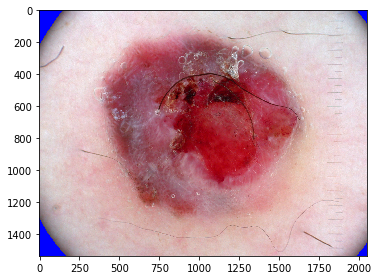

Rectangle correspondant à une zone de peau saine :


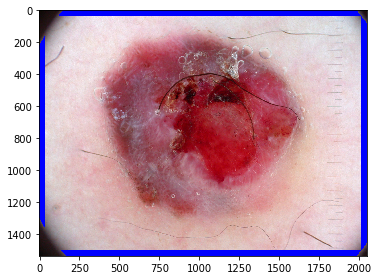

Image en noir et blanc correspondant à la distance à la peau saine :


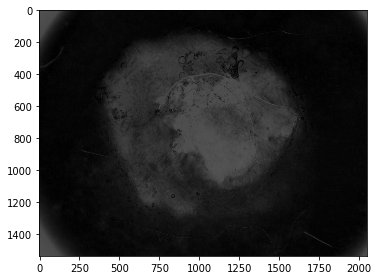

Application d'un filtre médian :


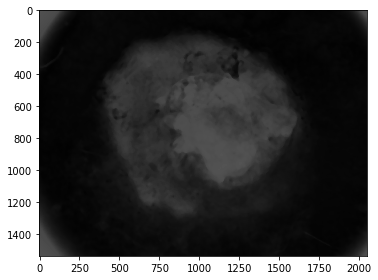

In [ ]:
print("Affichage du masque pour les bords noirs et pour les poils éventuels:")
if (poils):
    im = resize(im, (512,486),anti_aliasing=True)
    im_segmented = resize(im_segmented, (512,486),anti_aliasing=True)
    (l,c,k)= np.shape(im)
    mfinal, dirnormale, tablenligne = nettoyagemasque(calcul_complet_masque(im, im_segmented), selem1 = disk(3), selem2 = square(3))
    iminter_moyenne = interpolation_moy(im,mfinal)
else:
    iminter_moyenne = im

im_lab = conversion_couleur(iminter_moyenne)
masque = mask(im_lab)

print("Rectangle correspondant à une zone de peau saine :")
rectangle = rectangle_peau_saine(iminter_moyenne, im_lab, masque)

print("Image en noir et blanc correspondant à la distance à la peau saine :")
im_bw = black_and_white(rectangle, im_lab)

print("Application d'un filtre médian :")
im_smooth = filtre_median(im_bw)

Seuillage :

Application du seuil :


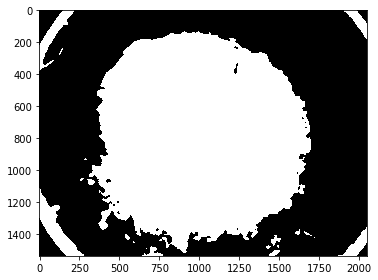

In [ ]:
print("Application du seuil :")
im_threshold = seuil(rectangle, masque, im_smooth, 0.2, 0.1)

Post processing :

Morphologie mathématique (closing) :


/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


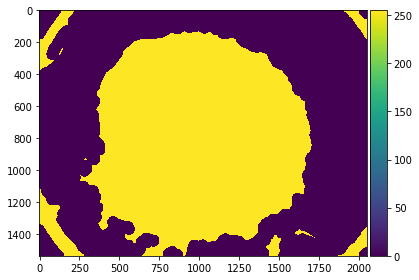

Récupération de la lésion en gardant uniquement la zone la plus grande :


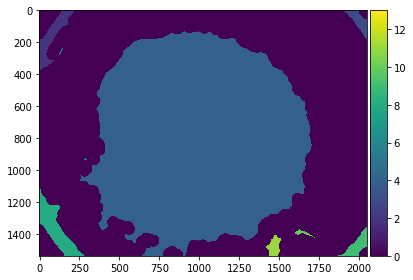

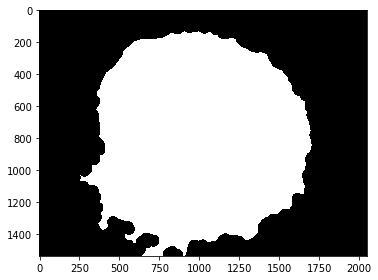

Bouchage des trous à l'intérieur de la lésion :


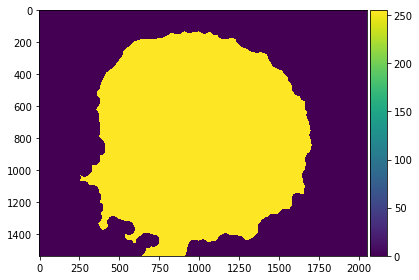

In [ ]:
print("Morphologie mathématique (closing) :")
if(poils): 
    im_opening = morpho.opening(im_threshold, morpho.disk(2))
    skio.imshow(im_opening)
    skio.show()
    im_closing = closing(im_opening)
else:
    im_closing = closing(im_threshold)
print("Récupération de la lésion en gardant uniquement la zone la plus grande :")
im_lesion = trouver_lesion(im_closing)
print("Bouchage des trous à l'intérieur de la lésion :")
im_final = remplir_trous(im_lesion)

In [ ]:
if(deux_passages):
    im_final2 = deuxieme_passage(im_smooth, im_final, rectangle, masque, 0.7, 0.2)

Résultat

Affichage du résultat et du coefficient de dice :


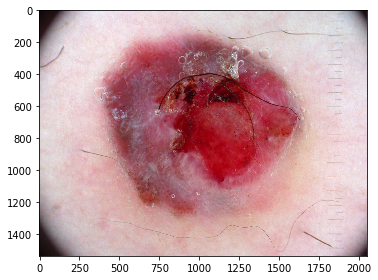

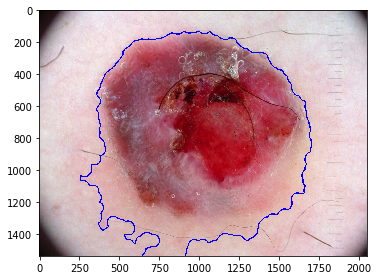

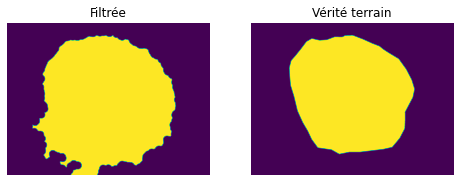

Coefficient de dice : 0.9001267751057943


In [ ]:
print("Affichage du résultat et du coefficient de dice :")
if (deux_passages):
    resultat(im_final2)
else:
    resultat(im_final)

# Bilan

La détection du contour de la lésion a été grandement améliorée à l'aide de la nouvelle version d'Otsu, notamment grâce au calcul de la couleur de la peau saine. 

Notre méthode reste tout de même limitée sur certaines images. Elle dépend en effet de coefficients qu'il est difficile de choisir puisque certains peuvent donner un très bon résultat pour certaines images et un mauvais résultat pour d'autres. De plus, ces coefficients premettent d'être plus ou moins large autour de la lésion, ce qui est difficile sans les connaissances médicales nécessaires. Nous pouvons comparer les lésions à leur image de référence mais les lésions sont parfois coupées assez grossièrement, ce que nous ne pouvons pas avoir avec notre programme. Cela rend la comparaison bien plus difficile.

Il y a en plus beaucoup d'autres paramètres sur lesquels nous pourrions jouer, comme la taille du filtre médian ou celle des disques utilisés pour les morphologies mathématiques.

Les erreurs que nous observons sont généralement dûes aux mêmes facteurs. Souvent, la zone de peau saine n'est pas assez grande pour que la méthode utilisée puisse déterminer efficacement la couleur, ce qui fausse grandement les résultats. C'est encore plus souvent le cas lorsqu'il y a un cadre noir. D'autres erreurs arrivent lorsqu'une partie de la lésion a une couleur proche de celle de la peau saine ou de la couleur des poils (bulles blanches, zones plus sombres, etc) : nous ne les détectons alors pas comme faisant partie de la lésion. Enfin, nous ne choisissons que la plus grande zone détectée. Lorsque la lésion est en 2 parties, si la morphologie mathématique n'est pas suffisante pour les relier alors nous perdons cette zone.


Dans l'ensemble notre programme est donc plutôt efficace mais il pourrait être grandement amélioré en modifiant quelques fonctions (par exemple en utilisant une autre forme qu'un rectangle pour détecter la peau saine, ou une meilleure détection des bords noirs) ou en utilisant l'intelligence artificielle.

##Références

[1] Border detection in dermoscopy images using statistical region merging, Celebi et al

[2] A simple weighted thresholding method for the segmentation of pigmented skin lesions in macroscopic images, Zortea

[3] Skin Lesion Segmentation Using Color Channel Optimization and Clustering-based Histogram Thresholding, Garnavietal

[4] Tim Lee, Vincent Ng, Richard Gallagher, Andrew Coldman, David McLean,
Dullrazor®: A software approach to hair removal from images